In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

import string
import re
import nltk
from nltk.corpus import stopwords as StopWords

from PIL import Image
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,log_loss
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Dataset
reviews = pd.read_csv("mussorie_reviews.csv")
reviews

,Review,Date of stay,Rating
0,Most beautiful stay at Mussoorie...such a gorg...,Date of stay: August 2021,"<span class=""ui_bubble_rating bubble_50""></span>"
1,NaN,NaN,NaN
2,The Savoy is one of those rare hotels that not...,Date of stay: October 2020,"<span class=""ui_bubble_rating bubble_50""></span>"
3,NaN,NaN,NaN
4,Def Best stay in Uttarakand ! Amazing nature. ...,Date of stay: November 2021,"<span class=""ui_bubble_rating bubble_50""></span>"
...,...,...,...
30386,It was a wonderful experience in Mussoorie. Gr...,Date of stay: May 2009,"<span class=""ui_bubble_rating bubble_40""></span>"
30387,NaN,NaN,NaN
30388,Sterling Resort at the first look doesnt seem ...,Date of stay: April 2009,"<span class=""ui_bubble_rating bubble_40""></span>"
30389,NaN,NaN,NaN


- Our Data has 3 columns- Review, Date of stay and Rating.

- Extract relevant words from the text from the "Review" column
- Extract Month and Year from "Date of Stay" column
- Extract numbers from the "Rating" column

In [3]:
# Check info about the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30391 entries, 0 to 30390
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        15196 non-null  object
 1   Date of stay  15180 non-null  object
 2   Rating        15196 non-null  object
dtypes: object(3)
memory usage: 712.4+ KB


- Dataset has all the columns of data type-Object
- Dataset has 30391 rows 

In [4]:
reviews.describe()

,Review,Date of stay,Rating
count,15196,15180,15196
unique,12808,175,5
top,"Amazing property with beautiful view, hospital...",Date of stay: October 2021,"<span class=""ui_bubble_rating bubble_50""></span>"
freq,121,994,11848


In [5]:
# Check for missing values
reviews.isnull().sum()

Review          15195
Date of stay    15211
Rating          15195
dtype: int64

- There are lots of missing values in all 3 columns of the dataset,so we will drop missing values

In [6]:
reviews.dropna(inplace=True)

In [7]:
# Again, check if missing values have been dropped 
reviews.isnull().sum()

Review          0
Date of stay    0
Rating          0
dtype: int64

In [8]:
# Also, drop duplicates if any
reviews.drop_duplicates(inplace=True)

In [9]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12796 entries, 0 to 30390
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        12796 non-null  object
 1   Date of stay  12796 non-null  object
 2   Rating        12796 non-null  object
dtypes: object(3)
memory usage: 399.9+ KB


So, now our dataset has 12796 entires with no missing values

In [10]:
reviews.Rating.head(1) 

0    <span class="ui_bubble_rating bubble_50"></span>
Name: Rating, dtype: object

- If you check the Rating column, actual Rating needs to be extracted

In [11]:
reviews["Rating"] = reviews["Rating"].apply(lambda x:re.findall("\d",x)[0])
reviews

,Review,Date of stay,Rating
0,Most beautiful stay at Mussoorie...such a gorg...,Date of stay: August 2021,5
2,The Savoy is one of those rare hotels that not...,Date of stay: October 2020,5
4,Def Best stay in Uttarakand ! Amazing nature. ...,Date of stay: November 2021,5
6,Very very friendly and efficient staff … loved...,Date of stay: November 2021,5
8,Exceptional property. Just great experience. V...,Date of stay: October 2021,5
...,...,...,...
30382,I stayed in this hotel with my 5 family member...,Date of stay: May 2008,4
30384,the best histrocally place in india,Date of stay: April 2007,5
30386,It was a wonderful experience in Mussoorie. Gr...,Date of stay: May 2009,4
30388,Sterling Resort at the first look doesnt seem ...,Date of stay: April 2009,4


In [12]:
# Map positive,negative and neutral reviews
reviews["Sentiment"]=reviews["Rating"].map({"5":"Positive","4":"Positive","3":"Neutral","2":"Negative","1":"Negative"}) 

In [13]:
reviews

,Review,Date of stay,Rating,Sentiment
0,Most beautiful stay at Mussoorie...such a gorg...,Date of stay: August 2021,5,Positive
2,The Savoy is one of those rare hotels that not...,Date of stay: October 2020,5,Positive
4,Def Best stay in Uttarakand ! Amazing nature. ...,Date of stay: November 2021,5,Positive
6,Very very friendly and efficient staff … loved...,Date of stay: November 2021,5,Positive
8,Exceptional property. Just great experience. V...,Date of stay: October 2021,5,Positive
...,...,...,...,...
30382,I stayed in this hotel with my 5 family member...,Date of stay: May 2008,4,Positive
30384,the best histrocally place in india,Date of stay: April 2007,5,Positive
30386,It was a wonderful experience in Mussoorie. Gr...,Date of stay: May 2009,4,Positive
30388,Sterling Resort at the first look doesnt seem ...,Date of stay: April 2009,4,Positive


In [14]:
# Extract Year from Date of Stay
reviews['Year']=reviews['Date of stay'].apply (lambda x:"".join(re.findall("\d\d\d\d",x)))

In [15]:
reviews

,Review,Date of stay,Rating,Sentiment,Year
0,Most beautiful stay at Mussoorie...such a gorg...,Date of stay: August 2021,5,Positive,2021
2,The Savoy is one of those rare hotels that not...,Date of stay: October 2020,5,Positive,2020
4,Def Best stay in Uttarakand ! Amazing nature. ...,Date of stay: November 2021,5,Positive,2021
6,Very very friendly and efficient staff … loved...,Date of stay: November 2021,5,Positive,2021
8,Exceptional property. Just great experience. V...,Date of stay: October 2021,5,Positive,2021
...,...,...,...,...,...
30382,I stayed in this hotel with my 5 family member...,Date of stay: May 2008,4,Positive,2008
30384,the best histrocally place in india,Date of stay: April 2007,5,Positive,2007
30386,It was a wonderful experience in Mussoorie. Gr...,Date of stay: May 2009,4,Positive,2009
30388,Sterling Resort at the first look doesnt seem ...,Date of stay: April 2009,4,Positive,2009


In [16]:
# Extract Month from Date of Stay column
reviews["Month of stay"] = reviews["Date of stay"].apply(lambda x: "".join(re.findall(r'(Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)', x)))
reviews

,Review,Date of stay,Rating,Sentiment,Year,Month of stay
0,Most beautiful stay at Mussoorie...such a gorg...,Date of stay: August 2021,5,Positive,2021,August
2,The Savoy is one of those rare hotels that not...,Date of stay: October 2020,5,Positive,2020,October
4,Def Best stay in Uttarakand ! Amazing nature. ...,Date of stay: November 2021,5,Positive,2021,November
6,Very very friendly and efficient staff … loved...,Date of stay: November 2021,5,Positive,2021,November
8,Exceptional property. Just great experience. V...,Date of stay: October 2021,5,Positive,2021,October
...,...,...,...,...,...,...
30382,I stayed in this hotel with my 5 family member...,Date of stay: May 2008,4,Positive,2008,May
30384,the best histrocally place in india,Date of stay: April 2007,5,Positive,2007,April
30386,It was a wonderful experience in Mussoorie. Gr...,Date of stay: May 2009,4,Positive,2009,May
30388,Sterling Resort at the first look doesnt seem ...,Date of stay: April 2009,4,Positive,2009,April


In [17]:
# Drop all rows for the year <2018
reviews.drop(reviews[reviews['Year'] < '2018'].index,axis=0,inplace=True)

In [18]:
reviews.Year.unique()

array(['2021', '2020', '2019', '2018'], dtype=object)

In [19]:
# Keep on;y positive and negative sentiments, drop rows with neutral sentiments
reviews.drop(reviews[reviews['Sentiment'] == "Neutral"].index,axis=0,inplace=True)

In [20]:
reviews.Sentiment.unique()

array(['Positive', 'Negative'], dtype=object)

In [21]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8293 entries, 0 to 29156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Review         8293 non-null   object
 1   Date of stay   8293 non-null   object
 2   Rating         8293 non-null   object
 3   Sentiment      8293 non-null   object
 4   Year           8293 non-null   object
 5   Month of stay  8293 non-null   object
dtypes: object(6)
memory usage: 453.5+ KB


- Now our dataset has 8293 entries with 6 columns

In [22]:
reviews.Sentiment.value_counts(normalize=True)

Positive    0.974195
Negative    0.025805
Name: Sentiment, dtype: float64

- This dataset is imbalanced dataset, as positive sentiment is 97.4 % and negative sentiment is merely 2.58%

In [23]:
# Shuffle the dataset
reviews = reviews.sample(frac=1)
reviews

,Review,Date of stay,Rating,Sentiment,Year,Month of stay
28016,We as a couple have stayed in many resorts acr...,Date of stay: December 2018,2,Negative,2018,December
9318,Very Bad Customer Satisfaction. Employers are ...,Date of stay: March 2020,1,Negative,2020,March
7694,I had booked this property based on its fantas...,Date of stay: January 2020,5,Positive,2020,January
20284,We enjoyed our stay at mussoorie. Everything w...,Date of stay: May 2019,5,Positive,2019,May
28294,Servies was very nice🙏💖💖💖💖🤔💙💙. Food was very ...,Date of stay: August 2018,5,Positive,2018,August
...,...,...,...,...,...,...
1978,We had a great stay. The staff were very helpf...,Date of stay: December 2019,5,Positive,2019,December
28076,One of the best resorts in Mussoorie and has a...,Date of stay: November 2018,5,Positive,2018,November
7394,Amazing property with best valley view and roo...,Date of stay: August 2021,5,Positive,2021,August
28828,"No doubt the road was very narrow,it was raini...",Date of stay: June 2018,5,Positive,2018,June


In [24]:
# Drop Date of Stay and Reting column
reviews.drop(['Date of stay', 'Rating'], axis=1, inplace=True)

In [25]:
reviews

,Review,Sentiment,Year,Month of stay
28016,We as a couple have stayed in many resorts acr...,Negative,2018,December
9318,Very Bad Customer Satisfaction. Employers are ...,Negative,2020,March
7694,I had booked this property based on its fantas...,Positive,2020,January
20284,We enjoyed our stay at mussoorie. Everything w...,Positive,2019,May
28294,Servies was very nice🙏💖💖💖💖🤔💙💙. Food was very ...,Positive,2018,August
...,...,...,...,...
1978,We had a great stay. The staff were very helpf...,Positive,2019,December
28076,One of the best resorts in Mussoorie and has a...,Positive,2018,November
7394,Amazing property with best valley view and roo...,Positive,2021,August
28828,"No doubt the road was very narrow,it was raini...",Positive,2018,June


In [26]:
# Creating a function to preprocess data
def preprocess_data(text):
    """
    Returns text after removing numbers, punctuations, urls, emojis, html tags and lowercasing all the words in given text.
    """
    text = re.sub(r'[0-9]+', '', str(text))   # removing numbers
    text = re.sub(r'[^\w\s]', '', str(text))   # removing punctuations
    text = " ".join(x.lower() for x in text.split())  # lower casing the text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # removing urls
    text = re.sub(r'<.*?>', '', text) # removing html tags
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = " ".join(x for x in text.split() if x not in StopWords.words('english'))
    return text


In [27]:
# Apply preprocess_data function to review column
reviews["Preprocessed_reviews"] = reviews["Review"].apply(lambda x: preprocess_data(x))
reviews

,Review,Sentiment,Year,Month of stay,Preprocessed_reviews
28016,We as a couple have stayed in many resorts acr...,Negative,2018,December,couple stayed many resorts across globe one ev...
9318,Very Bad Customer Satisfaction. Employers are ...,Negative,2020,March,bad customer satisfaction employers good facil...
7694,I had booked this property based on its fantas...,Positive,2020,January,booked property based fantastic reviews proper...
20284,We enjoyed our stay at mussoorie. Everything w...,Positive,2019,May,enjoyed stay mussoorie everything great great ...
28294,Servies was very nice🙏💖💖💖💖🤔💙💙. Food was very ...,Positive,2018,August,servies nice food yummy room view great outdoo...
...,...,...,...,...,...
1978,We had a great stay. The staff were very helpf...,Positive,2019,December,great stay staff helpful cooperative excellent...
28076,One of the best resorts in Mussoorie and has a...,Positive,2018,November,one best resorts mussoorie good view rooms sta...
7394,Amazing property with best valley view and roo...,Positive,2021,August,amazing property best valley view rooms proper...
28828,"No doubt the road was very narrow,it was raini...",Positive,2018,June,doubt road narrowit raining heavely shown movi...


In [28]:
# Create a column for number of reviews
reviews["Word_count"] = reviews["Review"].apply(lambda x: len(str(x).split()))
reviews.head()

,Review,Sentiment,Year,Month of stay,Preprocessed_reviews,Word_count
28016,We as a couple have stayed in many resorts acr...,Negative,2018,December,couple stayed many resorts across globe one ev...,148
9318,Very Bad Customer Satisfaction. Employers are ...,Negative,2020,March,bad customer satisfaction employers good facil...,38
7694,I had booked this property based on its fantas...,Positive,2020,January,booked property based fantastic reviews proper...,148
20284,We enjoyed our stay at mussoorie. Everything w...,Positive,2019,May,enjoyed stay mussoorie everything great great ...,34
28294,Servies was very nice🙏💖💖💖💖🤔💙💙. Food was very ...,Positive,2018,August,servies nice food yummy room view great outdoo...,32


In [29]:
# Create a column for no. of unique words
reviews["Unique_word_count"] = reviews["Review"].apply(lambda x: len(set(str(x).split())))
reviews.head()

,Review,Sentiment,Year,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count
28016,We as a couple have stayed in many resorts acr...,Negative,2018,December,couple stayed many resorts across globe one ev...,148,101
9318,Very Bad Customer Satisfaction. Employers are ...,Negative,2020,March,bad customer satisfaction employers good facil...,38,33
7694,I had booked this property based on its fantas...,Positive,2020,January,booked property based fantastic reviews proper...,148,103
20284,We enjoyed our stay at mussoorie. Everything w...,Positive,2019,May,enjoyed stay mussoorie everything great great ...,34,31
28294,Servies was very nice🙏💖💖💖💖🤔💙💙. Food was very ...,Positive,2018,August,servies nice food yummy room view great outdoo...,32,25


In [30]:
# Create a column for no.of stop words in review
stop_words=StopWords.words('english')
reviews["Stopword_count"]=reviews["Review"].apply(lambda x:len([w for w in str(x).lower().split() if w not in stop_words]))
reviews.head()

,Review,Sentiment,Year,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count,Stopword_count
28016,We as a couple have stayed in many resorts acr...,Negative,2018,December,couple stayed many resorts across globe one ev...,148,101,75
9318,Very Bad Customer Satisfaction. Employers are ...,Negative,2020,March,bad customer satisfaction employers good facil...,38,33,22
7694,I had booked this property based on its fantas...,Positive,2020,January,booked property based fantastic reviews proper...,148,103,84
20284,We enjoyed our stay at mussoorie. Everything w...,Positive,2019,May,enjoyed stay mussoorie everything great great ...,34,31,24
28294,Servies was very nice🙏💖💖💖💖🤔💙💙. Food was very ...,Positive,2018,August,servies nice food yummy room view great outdoo...,32,25,22


In [31]:
# Create a word column for average word length in a review
reviews['Avg_word_length'] = reviews["Review"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
reviews.head() 

,Review,Sentiment,Year,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count,Stopword_count,Avg_word_length
28016,We as a couple have stayed in many resorts acr...,Negative,2018,December,couple stayed many resorts across globe one ev...,148,101,75,4.317568
9318,Very Bad Customer Satisfaction. Employers are ...,Negative,2020,March,bad customer satisfaction employers good facil...,38,33,22,4.736842
7694,I had booked this property based on its fantas...,Positive,2020,January,booked property based fantastic reviews proper...,148,103,84,4.317568
20284,We enjoyed our stay at mussoorie. Everything w...,Positive,2019,May,enjoyed stay mussoorie everything great great ...,34,31,24,5.029412
28294,Servies was very nice🙏💖💖💖💖🤔💙💙. Food was very ...,Positive,2018,August,servies nice food yummy room view great outdoo...,32,25,22,5.062500


In [32]:
# Create a columnn for nio. of character in review
reviews['Char_count'] = reviews["Review"].apply(lambda x: len(str(x)))
reviews.head()
 

,Review,Sentiment,Year,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count,Stopword_count,Avg_word_length,Char_count
28016,We as a couple have stayed in many resorts acr...,Negative,2018,December,couple stayed many resorts across globe one ev...,148,101,75,4.317568,790
9318,Very Bad Customer Satisfaction. Employers are ...,Negative,2020,March,bad customer satisfaction employers good facil...,38,33,22,4.736842,217
7694,I had booked this property based on its fantas...,Positive,2020,January,booked property based fantastic reviews proper...,148,103,84,4.317568,787
20284,We enjoyed our stay at mussoorie. Everything w...,Positive,2019,May,enjoyed stay mussoorie everything great great ...,34,31,24,5.029412,205
28294,Servies was very nice🙏💖💖💖💖🤔💙💙. Food was very ...,Positive,2018,August,servies nice food yummy room view great outdoo...,32,25,22,5.062500,197


In [33]:
# Create a column for no. of punctiuation in a review

reviews["Punctuation_count"] = reviews["Review"].apply(lambda x : len([p for p in str(x) if p in string.punctuation]))
reviews.head()
 

,Review,Sentiment,Year,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count,Stopword_count,Avg_word_length,Char_count,Punctuation_count
28016,We as a couple have stayed in many resorts acr...,Negative,2018,December,couple stayed many resorts across globe one ev...,148,101,75,4.317568,790,14
9318,Very Bad Customer Satisfaction. Employers are ...,Negative,2020,March,bad customer satisfaction employers good facil...,38,33,22,4.736842,217,5
7694,I had booked this property based on its fantas...,Positive,2020,January,booked property based fantastic reviews proper...,148,103,84,4.317568,787,25
20284,We enjoyed our stay at mussoorie. Everything w...,Positive,2019,May,enjoyed stay mussoorie everything great great ...,34,31,24,5.029412,205,8
28294,Servies was very nice🙏💖💖💖💖🤔💙💙. Food was very ...,Positive,2018,August,servies nice food yummy room view great outdoo...,32,25,22,5.062500,197,2


In [34]:
reviews['Preprocessed_reviews'][0]

'beautiful stay mussooriesuch gorgeous property really left heart back one memorable experience given beautiful birthday celebration green house food staff rooms excellent chef prakash negi fabulous went way ensure kids enjoyed good food well mussoorie beautiful hotel made trip special us location fabulous right heart mussoorie mall road could walk shopping whenever felt like time property feels secluded rooms quiet clouds descended balcony truly fabulous check'

### Exploratory Data Analysis

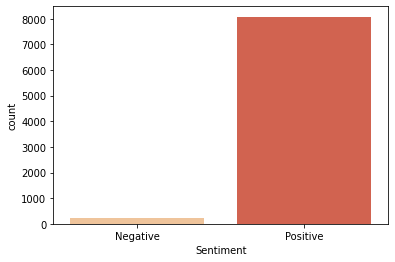

In [35]:
sns.countplot(x='Sentiment',data=reviews,palette='OrRd') 
plt.show()

In [36]:
reviews['Sentiment'].value_counts()

Positive    8079
Negative     214
Name: Sentiment, dtype: int64

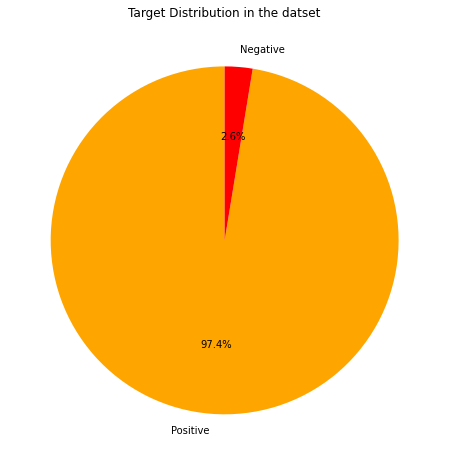

In [37]:
# Create a pie chat for target distribution in the dataset
plt.figure(figsize=(15,8))
s = reviews['Sentiment'].value_counts().plot(kind='pie',startangle=90,autopct="%1.1f%%",colors=['orange', 'red'])

s.set_ylabel('')
s.set_title('Target Distribution in the datset')
plt.show()


In [38]:
def generate_ngrams(text,n_gram=1):
    
    """
    Returns ngrams for the given text
    text: for which we wanr ngrams
    n_gram: Value for ngram
    
    """
    
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

### Generate Unigrams

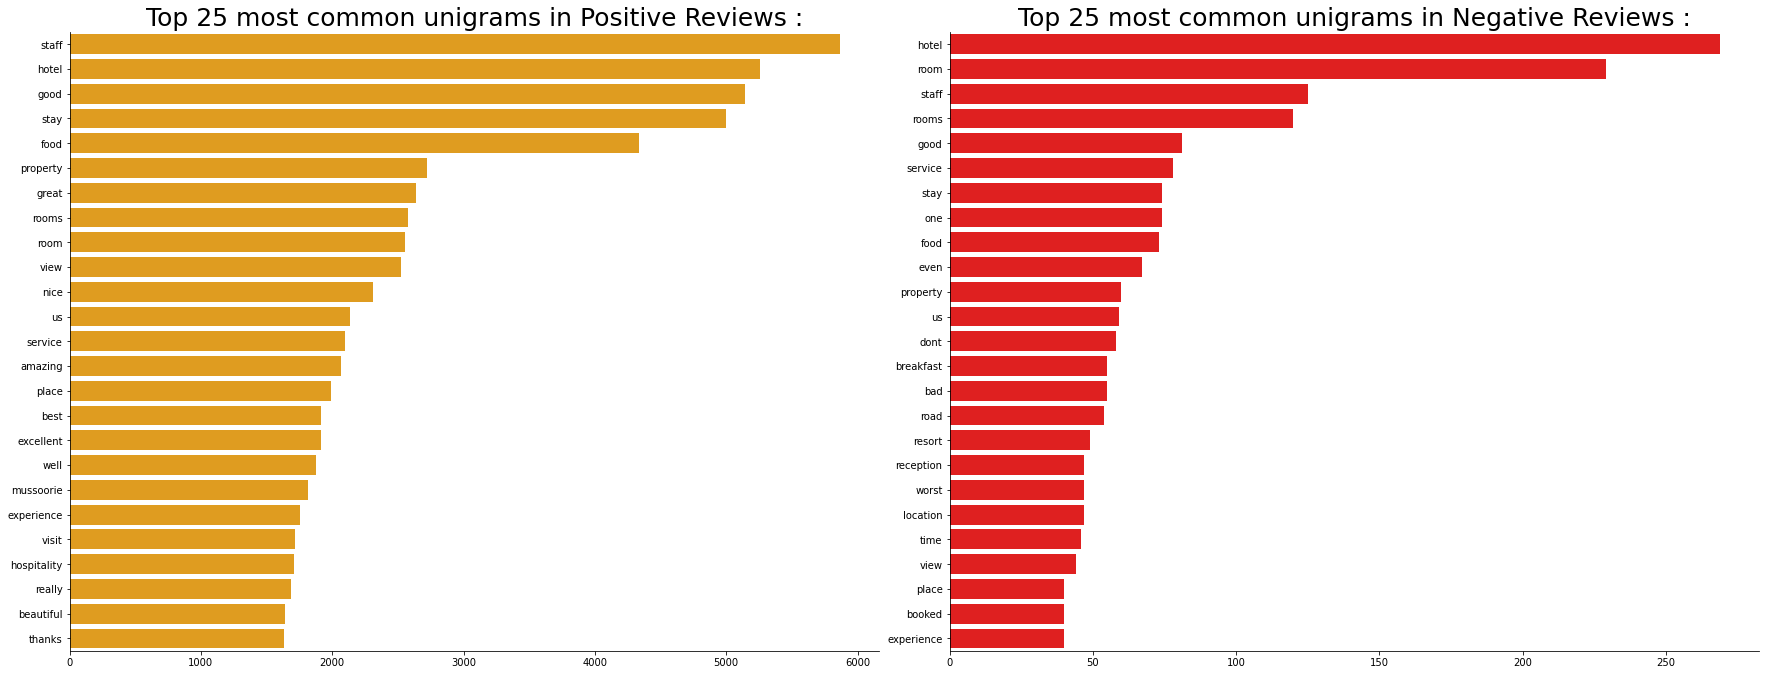

In [39]:
# Create  a default dictionary for positive and negative unigrams
pos_unigrams = defaultdict(int)
neg_unigrams = defaultdict(int)

# Number of ngrmas we want

N = 25

# Loop for updating value of unigrams
for review in reviews['Preprocessed_reviews'][reviews['Sentiment']=='Positive']:
    for word in generate_ngrams(review):
        pos_unigrams[word] +=1
        
for review in reviews['Preprocessed_reviews'][reviews['Sentiment']=='Negative']:
    for word in generate_ngrams(review):
        neg_unigrams[word] +=1
        
#craete dataframs using default dictionaries
df_pos_unigrams = pd.DataFrame(sorted(pos_unigrams.items(),key=lambda x: x[1])[::-1])
df_neg_unigrams = pd.DataFrame(sorted(neg_unigrams.items(),key=lambda x: x[1])[::-1])


fig,axes = plt.subplots(ncols=2,figsize=(25,10))
plt.tight_layout(pad=4.0)
                
# Plot positive and negative dataset

sns.despine()
sns.barplot(y= df_pos_unigrams[0].values[:N], x = df_pos_unigrams[1].values[:N],ax=axes[0],color="orange")
sns.barplot(y= df_neg_unigrams[0].values[:N], x = df_neg_unigrams[1].values[:N],ax=axes[1],color="red")

 

axes[0].set_title(f'Top {N} most common unigrams in Positive Reviews :', fontsize=25)
axes[1].set_title(f'Top {N} most common unigrams in Negative Reviews :', fontsize=25)              
                 
plt.show()

### Generate Bigrams

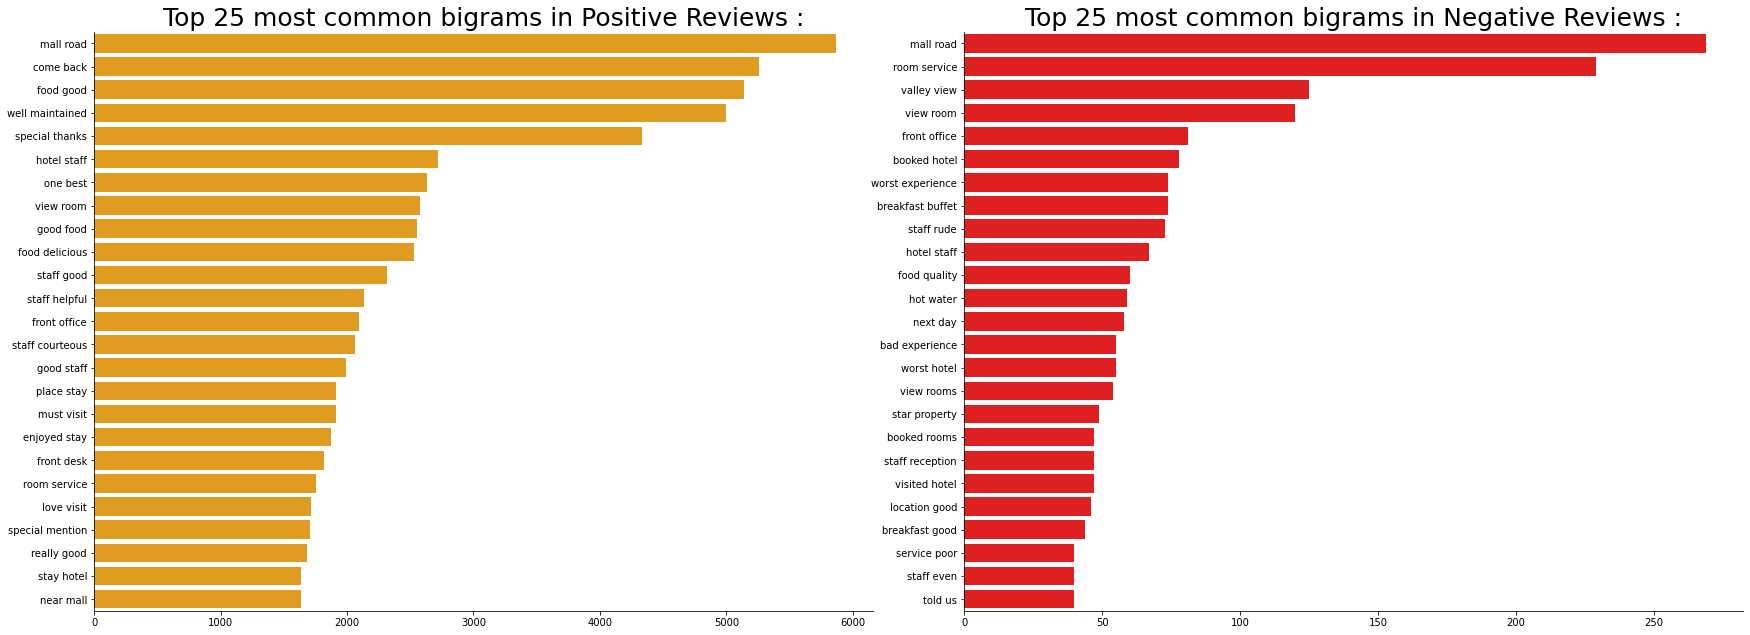

In [40]:
# Create  a default dictionary for positive and negative bigrams
pos_bigrams = defaultdict(int)
neg_bigrams = defaultdict(int)

# Number of ngrmas we want

N = 25

# Loop for updating value of bigrams
for review in reviews['Preprocessed_reviews'][reviews['Sentiment']=='Positive']:
    for word in generate_ngrams(review,n_gram=2):
        pos_bigrams[word] +=1
        
for review in reviews['Preprocessed_reviews'][reviews['Sentiment']=='Negative']:
    for word in generate_ngrams(review,n_gram=2):
        neg_bigrams[word] +=1
        
#craete dataframs using default dictionaries
df_pos_bigrams = pd.DataFrame(sorted(pos_bigrams.items(),key=lambda x: x[1])[::-1])
df_neg_bigrams = pd.DataFrame(sorted(neg_bigrams.items(),key=lambda x: x[1])[::-1])


fig,axes = plt.subplots(ncols=2,figsize=(25,10))
plt.tight_layout(pad=6.0)
                
# Plot positive and negative dataset

sns.despine()
sns.barplot(y= df_pos_bigrams[0].values[:N], x = df_pos_unigrams[1].values[:N],ax=axes[0],color="orange")
sns.barplot(y= df_neg_bigrams[0].values[:N], x = df_neg_unigrams[1].values[:N],ax=axes[1],color="red")

 

axes[0].set_title(f'Top {N} most common bigrams in Positive Reviews :', fontsize=25)
axes[1].set_title(f'Top {N} most common bigrams in Negative Reviews :', fontsize=25)              
                 
plt.show()

 ### Generate Trigrams

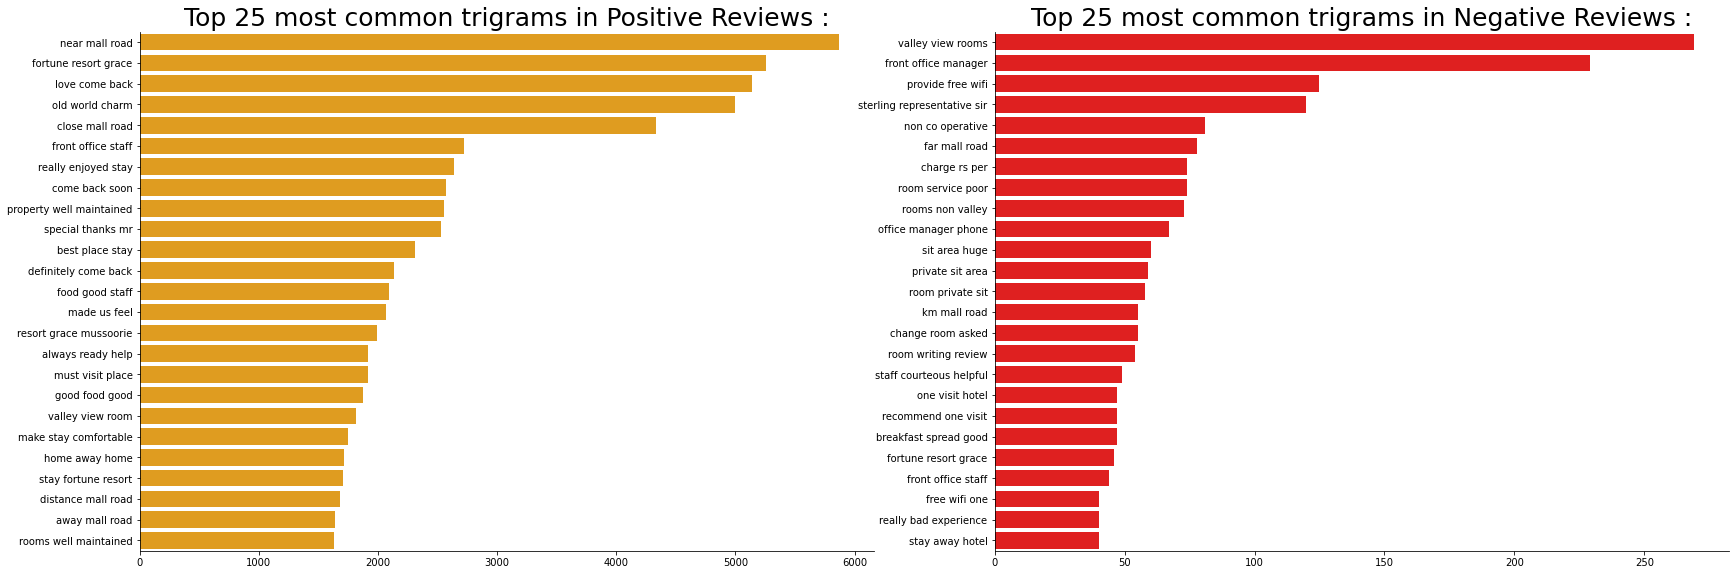

In [41]:
# Create  a default dictionary for positive and negative bigrams
pos_trigrams = defaultdict(int)
neg_trigrams = defaultdict(int)

# Number of ngrmas we want

N = 25

# Loop for updating value of bigrams
for review in reviews['Preprocessed_reviews'][reviews['Sentiment']=='Positive']:
    for word in generate_ngrams(review,n_gram=3):
        pos_trigrams[word] +=1
        
for review in reviews['Preprocessed_reviews'][reviews['Sentiment']=='Negative']:
    for word in generate_ngrams(review,n_gram=3):
        neg_trigrams[word] +=1
        
#craete dataframs using default dictionaries
df_pos_trigrams = pd.DataFrame(sorted(pos_trigrams.items(),key=lambda x: x[1])[::-1])
df_neg_trigrams = pd.DataFrame(sorted(neg_trigrams.items(),key=lambda x: x[1])[::-1])


fig,axes = plt.subplots(ncols=2,figsize=(25,10))
plt.tight_layout(pad=9.0)
                
# Plot positive and negative dataset

sns.despine()
sns.barplot(y= df_pos_trigrams[0].values[:N], x = df_pos_unigrams[1].values[:N],ax=axes[0],color="orange",)
sns.barplot(y= df_neg_trigrams[0].values[:N], x = df_neg_unigrams[1].values[:N],ax=axes[1],color="red")

 

axes[0].set_title(f'Top {N} most common trigrams in Positive Reviews :', fontsize=25)
axes[1].set_title(f'Top {N} most common trigrams in Negative Reviews :', fontsize=25)              
                 
plt.show()

### No.of reviews in each month

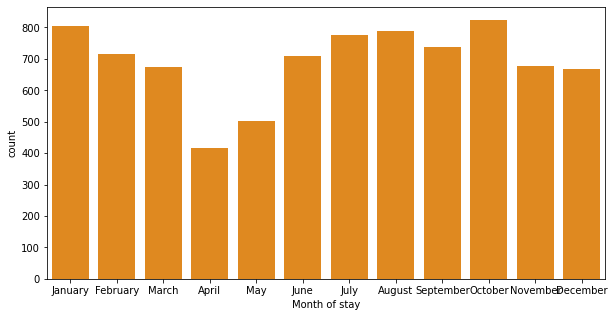

In [42]:
plt.figure(figsize=(10,5))
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
sns.despine()  # Remove the top and right spines from plot
sns.countplot(x='Month of stay',data=reviews,order=months,color='darkorange')
plt.show()

- More no. of reviews were obtained from the month of January and October
- April is the month of least no.of reviews 

### No. of reviews in each year

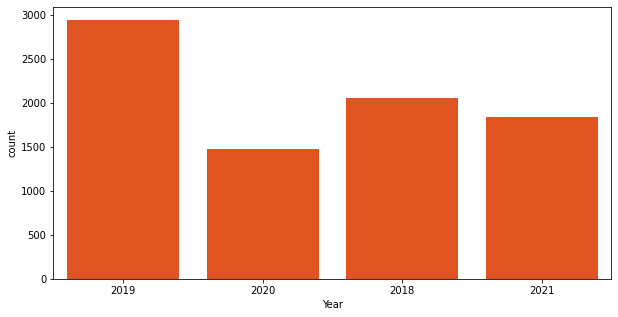

In [43]:
plt.figure(figsize=(10,5))
year = ['2019', '2020', '2018', '2021']
sns.despine()  # Remove the top and right spines from plot
sns.countplot(x='Year',data=reviews,order=year,color='orangered')
plt.show()

- 2019 was the year of bighest no.of reviews
- 2020 is obviously the year pf less reviews because of the pandemic

### Word count for the reviews

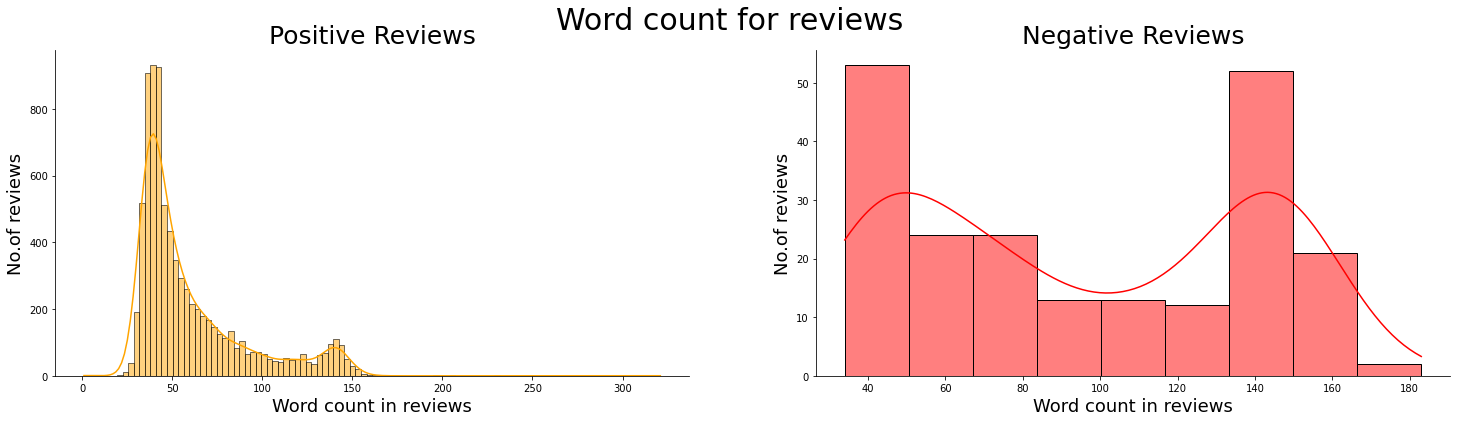

In [44]:
fig,axes = plt.subplots(ncols=2, figsize=(25,6))

sns.despine()
sns.histplot(ax=axes[0],x="Word_count",data=reviews[reviews['Sentiment']=='Positive'],kde=True,color='orange')
sns.histplot(ax=axes[1],x="Word_count",data=reviews[reviews['Sentiment']=='Negative'],kde=True,color='red')

axes[0].set_title("Positive Reviews",fontsize=25)
axes[1].set_title("Negative Reviews",fontsize=25)

axes[0].set_ylabel("No.of reviews",fontsize=18)
axes[1].set_ylabel("No.of reviews",fontsize=18)
axes[0].set_xlabel("Word count in reviews",fontsize=18)
axes[1].set_xlabel("Word count in reviews",fontsize=18)

fig.suptitle("Word count for reviews", fontsize=30)
plt.show()

### Plot Unique Word Count in reviews

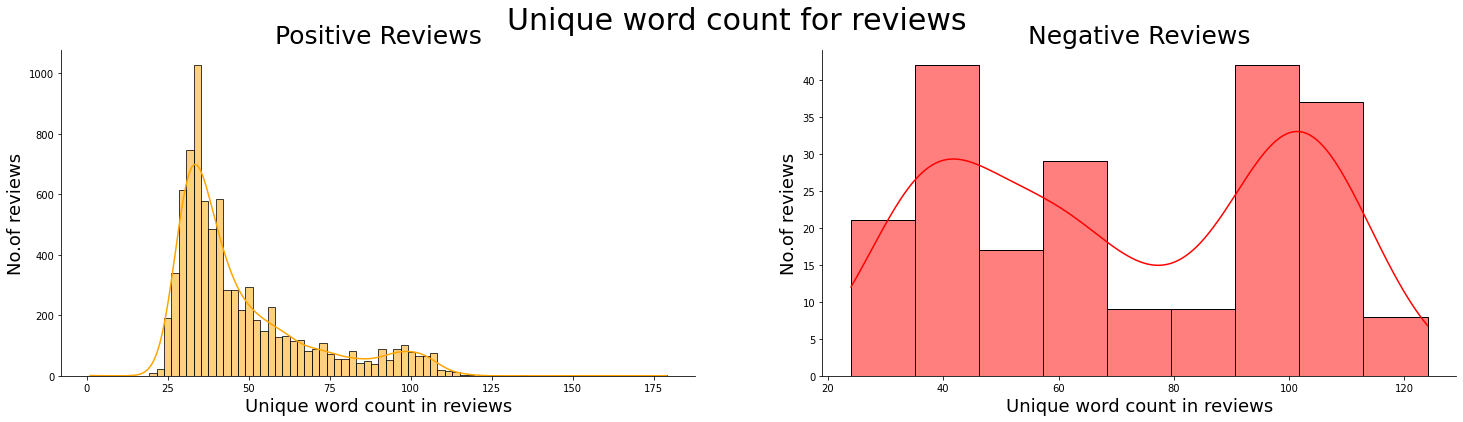

In [45]:
fig,axes = plt.subplots(ncols=2, figsize=(25,6))

sns.despine()
sns.histplot(ax=axes[0],x="Unique_word_count",data=reviews[reviews['Sentiment']=='Positive'],kde=True,color='orange')
sns.histplot(ax=axes[1],x="Unique_word_count",data=reviews[reviews['Sentiment']=='Negative'],kde=True,color='red')

axes[0].set_title("Positive Reviews",fontsize=25)
axes[1].set_title("Negative Reviews",fontsize=25)

axes[0].set_ylabel("No.of reviews",fontsize=18)
axes[1].set_ylabel("No.of reviews",fontsize=18)
axes[0].set_xlabel("Unique word count in reviews",fontsize=18)
axes[1].set_xlabel("Unique word count in reviews",fontsize=18)

fig.suptitle("Unique word count for reviews", fontsize=30)
plt.show()

### Plot No.of STOPWORDS

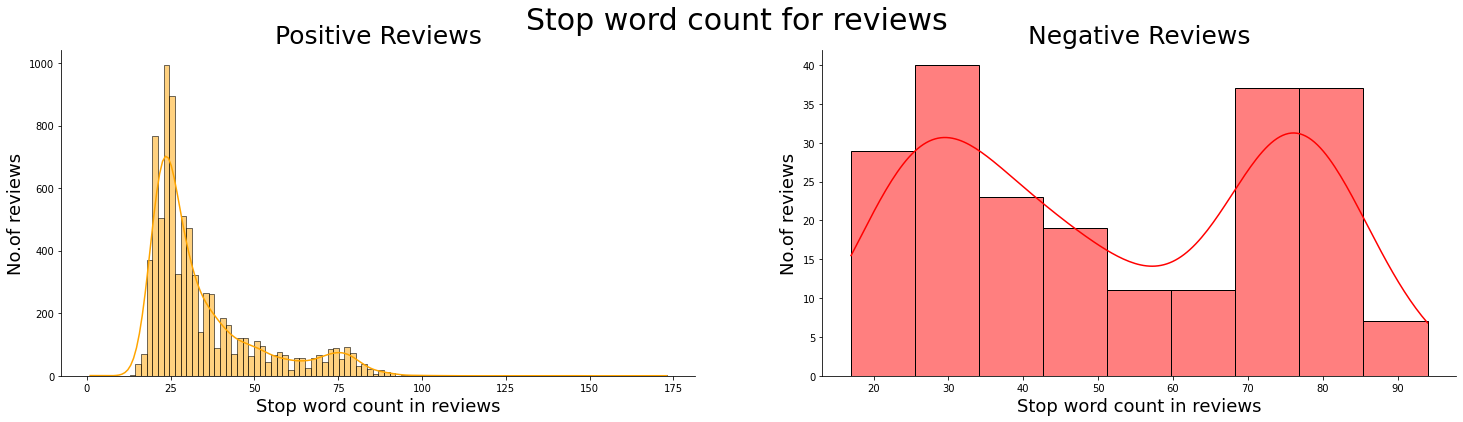

In [46]:
fig,axes = plt.subplots(ncols=2, figsize=(25,6))

sns.despine()
sns.histplot(ax=axes[0],x="Stopword_count",data=reviews[reviews['Sentiment']=='Positive'],kde=True,color='orange')
sns.histplot(ax=axes[1],x="Stopword_count",data=reviews[reviews['Sentiment']=='Negative'],kde=True,color='red')

axes[0].set_title("Positive Reviews",fontsize=25)
axes[1].set_title("Negative Reviews",fontsize=25)

axes[0].set_ylabel("No.of reviews",fontsize=18)
axes[1].set_ylabel("No.of reviews",fontsize=18)
axes[0].set_xlabel("Stop word count in reviews",fontsize=18)
axes[1].set_xlabel("Stop word count in reviews",fontsize=18)

fig.suptitle("Stop word count for reviews", fontsize=30)
plt.show()

### Plot Character Count 

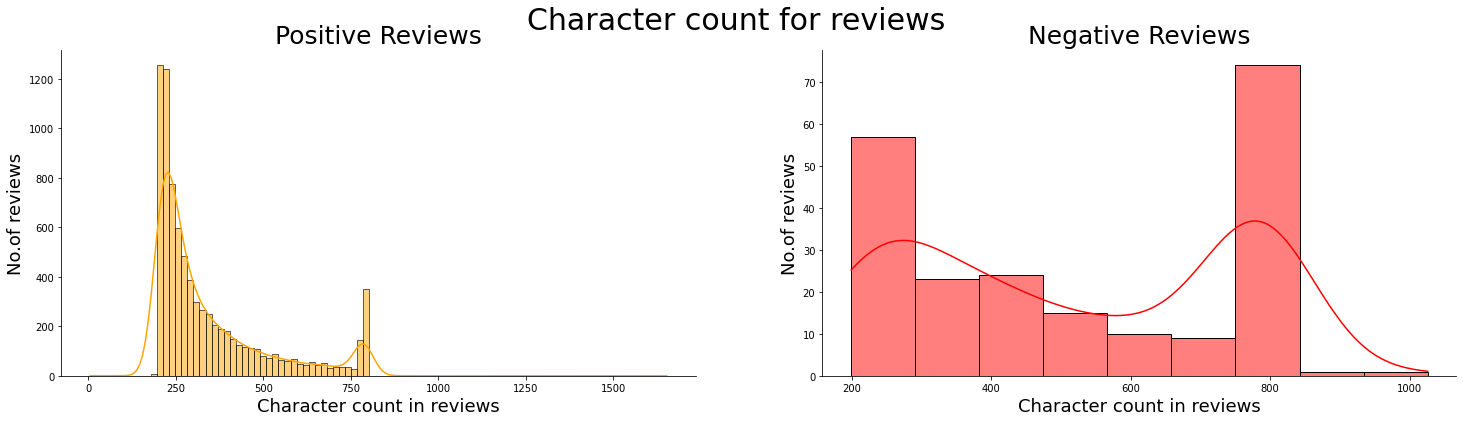

In [47]:
fig,axes = plt.subplots(ncols=2, figsize=(25,6))

sns.despine()
sns.histplot(ax=axes[0],x="Char_count",data=reviews[reviews['Sentiment']=='Positive'],kde=True,color='orange')
sns.histplot(ax=axes[1],x="Char_count",data=reviews[reviews['Sentiment']=='Negative'],kde=True,color='red')

axes[0].set_title("Positive Reviews",fontsize=25)
axes[1].set_title("Negative Reviews",fontsize=25)

axes[0].set_ylabel("No.of reviews",fontsize=18)
axes[1].set_ylabel("No.of reviews",fontsize=18)
axes[0].set_xlabel("Character count in reviews",fontsize=18)
axes[1].set_xlabel("Character count in reviews",fontsize=18)

fig.suptitle("Character count for reviews", fontsize=30)
plt.show()

### Plot Punctuation Count

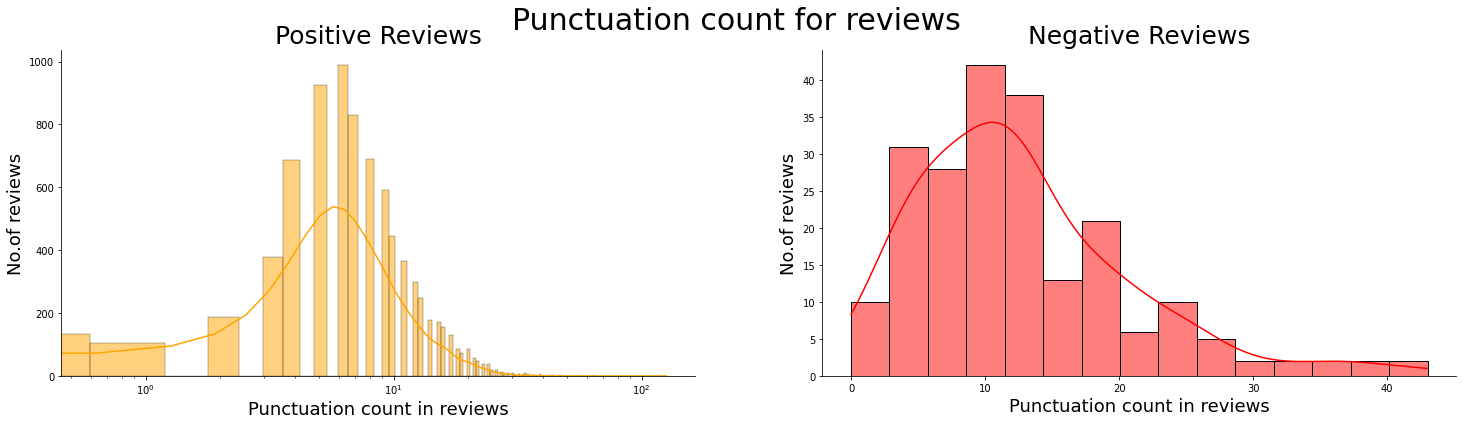

In [48]:
fig,axes = plt.subplots(ncols=2, figsize=(25,6))

sns.despine()
sns.histplot(ax=axes[0],x="Punctuation_count",data=reviews[reviews['Sentiment']=='Positive'],kde=True,color='orange')
sns.histplot(ax=axes[1],x="Punctuation_count",data=reviews[reviews['Sentiment']=='Negative'],kde=True,color='red')

axes[0].set_title("Positive Reviews",fontsize=25)
axes[1].set_title("Negative Reviews",fontsize=25)
axes[0].set_xscale('log')

axes[0].set_ylabel("No.of reviews",fontsize=18)
axes[1].set_ylabel("No.of reviews",fontsize=18)
axes[0].set_xlabel("Punctuation count in reviews",fontsize=18)
axes[1].set_xlabel("Punctuation count in reviews",fontsize=18)

fig.suptitle("Punctuation count for reviews", fontsize=30)
plt.show()

### Plot a WordCloud for positive reviews

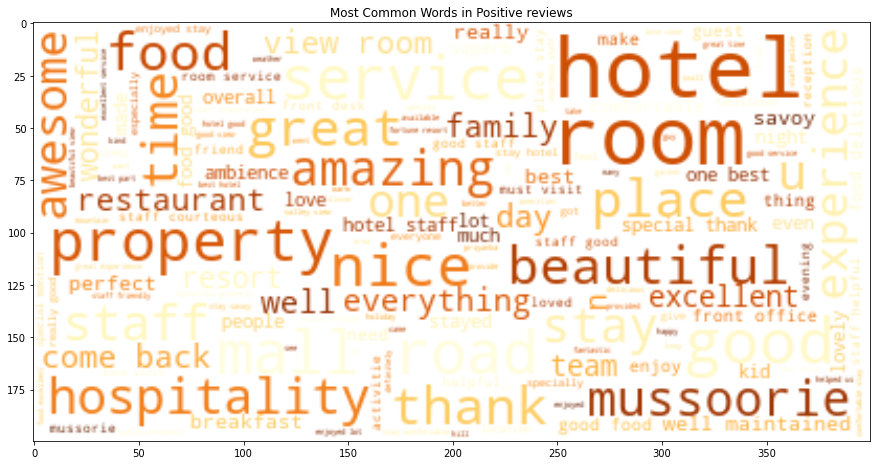

In [49]:
#pos_mask = np.array(Image.open(d+ 'hotel.png'))
positive = " ".join(review for review in reviews['Preprocessed_reviews'][reviews['Sentiment']=='Positive'])
wordcloud = WordCloud(background_color='white',stopwords= STOPWORDS,max_words=500, max_font_size=40,random_state=42,colormap='YlOrBr').generate(positive)
plt.figure(figsize=(15,10))
plt.title("Most Common Words in Positive reviews")
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis=("off")
plt.show()

### Plot Word Count for Negative reviews

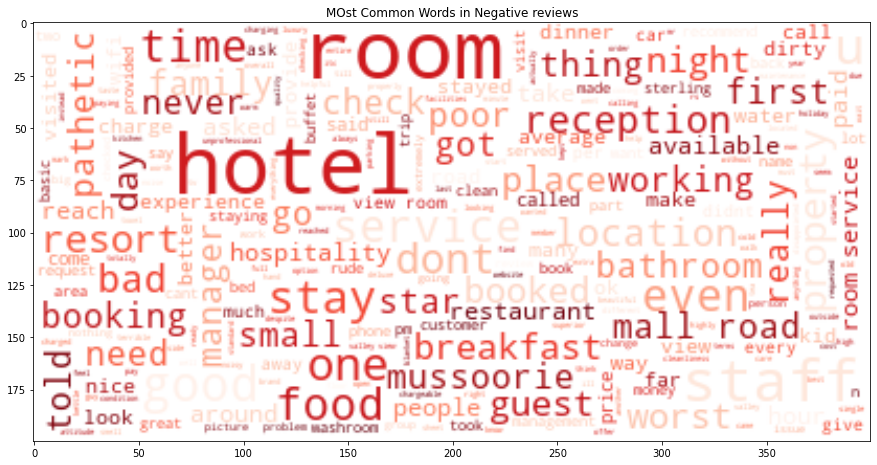

In [50]:
negative = " ".join(review for review in reviews['Preprocessed_reviews'][reviews['Sentiment']=='Negative'])
wordcloud = WordCloud(background_color='white',stopwords= STOPWORDS,max_words=500, max_font_size=40,random_state=42,colormap='Reds').generate(negative)
plt.figure(figsize=(15,10))
plt.title("MOst Common Words in Negative reviews")
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis=("off")
plt.show()

In [51]:
### Create Custom Words
all_text = " ".join(list(reviews["Preprocessed_reviews"]))
words = pd.Series(all_text.split(" "))
frequent_words = words.value_counts()[:20]
frequent_words

staff        5993
hotel        5528
good         5223
stay         5069
food         4409
room         2786
property     2782
rooms        2694
great        2651
view         2570
nice         2333
us           2193
service      2172
amazing      2071
place        2031
also         2014
best         1926
excellent    1916
well         1883
mussoorie    1840
dtype: int64

In [52]:
# Delete top 10 frequent words from the list
reviews["Preprocessed_reviews"] = reviews["Preprocessed_reviews"].apply(lambda x: " ".join([word for word in str(x).split() if word not in frequent_words]))

In [53]:
import streamlit as st
import pickle
import string
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer

ps = PorterStemmer()


def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))
    return " ".join(y)


In [54]:
# Label Encoder
le = LabelEncoder()
reviews['Sentiment'] = le.fit_transform(reviews['Sentiment'])

In [55]:
#Split the dataset
x_train,x_test,y_train,y_test = train_test_split(reviews['Review'],reviews['Sentiment'],stratify=reviews['Sentiment'],random_state=42,test_size=0.2,shuffle=True)

### Model Training

In [57]:
# Initializing TfidfVectorizer
tfidf = TfidfVectorizer(min_df=3,  max_features=3000, decode_error = "replace", preprocessor = preprocess_data,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

#Fitting Tfidf vectorizer to training dataset
tfidf.fit(list(x_train))

# Transform the train and   dataset

x_train_tfv =tfidf.transform(x_train)
x_train_tfv

<6634x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 206219 stored elements in Compressed Sparse Row format>

In [58]:
# Transform test dataset using the same tfidf vectorizer we fit on training datset
xtest_tfv = tfidf.transform(x_test)

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [60]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear',penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2,eval_metric='rmse')

In [61]:
clfs = (
        {'SVC':svc,
         'KNC':knc,
         'MNB':mnb,
         'DT': dtc, 
         'LR': lrc, 
         'RF': rfc, 
         'AdaBoost': abc, 
         'BgC': bc, 
         'ETC': etc,
         'GBDT':gbdt,
         'xgb':xgb
    
})

In [63]:
def train_classifier(clf,x_train_tfv,y_train,xtest_tfv,y_test):
    clf.fit(x_train_tfv,y_train)
    y_pred = clf.predict(xtest_tfv)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [64]:
train_classifier(svc,x_train_tfv,y_train,xtest_tfv,y_test)

(0.9873417721518988, 0.9877675840978594)

In [65]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    current_accuracy,current_precision = train_classifier(clf,x_train_tfv,y_train,xtest_tfv,y_test)
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9873417721518988
Precision -  0.9877675840978594
For  KNC
Accuracy -  0.974080771549126
Precision -  0.974080771549126
For  MNB
Accuracy -  0.9758890898131405
Precision -  0.9758454106280193
For  DT
Accuracy -  0.9819168173598554
Precision -  0.9847188264058679
For  LR
Accuracy -  0.9843279083785413
Precision -  0.9841656516443362
For  RF
Accuracy -  0.9813140446051839
Precision -  0.9811778992106861
For  AdaBoost
Accuracy -  0.9837251356238698
Precision -  0.9901295496607033
For  BgC
Accuracy -  0.9801084990958409
Precision -  0.9852851011649295
For  ETC
Accuracy -  0.9770946353224834
Precision -  0.9770253929866989
For  GBDT
Accuracy -  0.9819168173598554
Precision -  0.9847188264058679
For  xgb
Accuracy -  0.9861362266425557
Precision -  0.9865607819181429


In [66]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [67]:
performance_df

,Algorithm,Accuracy,Precision
6,AdaBoost,0.983725,0.990130
0,SVC,0.987342,0.987768
10,xgb,0.986136,0.986561
7,BgC,0.980108,0.985285
3,DT,0.981917,0.984719
9,GBDT,0.981917,0.984719
4,LR,0.984328,0.984166
5,RF,0.981314,0.981178
8,ETC,0.977095,0.977025
2,MNB,0.975889,0.975845


-Adaboost is giving us the best accuracy after changing the max_features=3000,precision score has been increased to 0.99%

In [68]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(abc,open('model.pkl','wb'))